In [59]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import LabelEncoder

In [2]:
!ls train/audio

_background_noise_  dog    four   left	  off	 seven	 three	wow
bed		    down   go	  marvin  on	 sheila  tree	yes
bird		    eight  happy  nine	  one	 six	 two	zero
cat		    five   house  no	  right  stop	 up


# Read data

In [41]:
# create json dataset with format: 
# [
#   {
#     "path": "path/to/audio/file",
#     "label": "label"
#   },
#   ...
# ]
path = 'train/audio'
data = []

for label in os.listdir(path):
    for file in os.listdir(f'{path}/{label}'):
        if file == 'README.md':
            continue
        data.append({
            'path': f'{path}/{label}/{file}',
            'label': label
        })

df = pd.DataFrame(data)
df


,path,label
0,train/audio/_background_noise_/white_noise.wav,_background_noise_
1,train/audio/_background_noise_/running_tap.wav,_background_noise_
2,train/audio/_background_noise_/dude_miaowing.wav,_background_noise_
3,train/audio/_background_noise_/pink_noise.wav,_background_noise_
4,train/audio/_background_noise_/exercise_bike.wav,_background_noise_
...,...,...
64722,train/audio/zero/3ff840aa_nohash_0.wav,zero
64723,train/audio/zero/db7c95b0_nohash_0.wav,zero
64724,train/audio/zero/637c702a_nohash_1.wav,zero
64725,train/audio/zero/9e42ae25_nohash_1.wav,zero


# Convert audio to spectrogram

In [45]:
def audio_to_spectrogram(file_path, max_pad_len=174):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    mfcc = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=20)
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc


In [46]:
# df['spectrogram'] = df['path'].apply(audio_to_spectrogram)
df['spectrogram'] = df['path'] 
for i in tqdm.tqdm(range(len(df))):
    df['spectrogram'][i] = audio_to_spectrogram(df['path'][i])


100%|██████████| 64727/64727 [03:39<00:00, 294.65it/s]


# Split dataset

In [69]:
# split data into train, validation, and test sets

X = np.array(df['spectrogram'].tolist())
X = X[..., np.newaxis]
y = np.array(df['label'].tolist())

# Assuming `y_train` and `y_test` are your categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [73]:
print(X_train.shape, X_val.shape, X_test.shape)

(41424, 20, 174, 1) (10357, 20, 174, 1) (12946, 20, 174, 1)


# Define model

In [71]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 18, 172, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 9, 86, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 84, 64)         18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 3, 42, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 40, 128)        73856     
                                                                 
 flatten_3 (Flatten)         (None, 5120)             

In [74]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
1295/1295 [==============================] - 34s 26ms/step - loss: 1.9523 - accuracy: 0.4224 - val_loss: 0.7404 - val_accuracy: 0.7745
Epoch 2/10
1295/1295 [==============================] - 33s 26ms/step - loss: 0.7812 - accuracy: 0.7665 - val_loss: 0.5334 - val_accuracy: 0.8390
Epoch 3/10
1295/1295 [==============================] - 33s 25ms/step - loss: 0.5614 - accuracy: 0.8340 - val_loss: 0.4378 - val_accuracy: 0.8721
Epoch 4/10
1295/1295 [==============================] - 34s 26ms/step - loss: 0.4748 - accuracy: 0.8631 - val_loss: 0.4058 - val_accuracy: 0.8800
Epoch 5/10
1295/1295 [==============================] - 34s 26ms/step - loss: 0.4159 - accuracy: 0.8792 - val_loss: 0.3828 - val_accuracy: 0.8946
Epoch 6/10
1295/1295 [==============================] - 34s 26ms/step - loss: 0.3868 - accuracy: 0.8887 - val_loss: 0.3871 - val_accuracy: 0.8931
Epoch 7/10
1295/1295 [==============================] - 33s 25ms/step - loss: 0.3595 - accuracy: 0.8962 - val_loss: 0.3732 -

In [75]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

405/405 - 2s - loss: 0.4570 - accuracy: 0.8843 - 2s/epoch - 5ms/step

Test accuracy: 0.8842886090278625


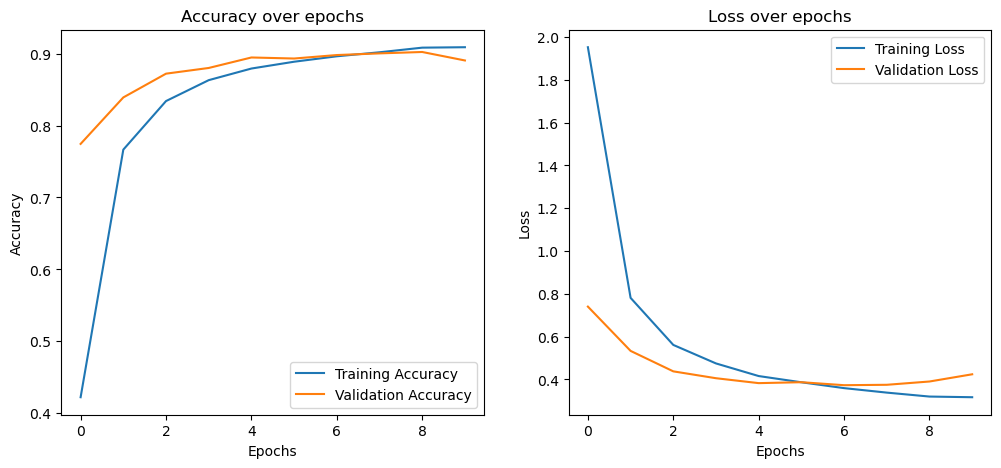

In [76]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
